## Abstract
A common workflow used in applied machine learning is illustrated through the use of a Binary Classification problem. The focus of this project is to predict the binary class label 0 or 1 of `y` based on a set of 50 features. 

## Introduction
Any predictive modeling machine learning project can be broken down into seven common tasks:
- Define the problem
- Do exploratory data analysis
- Prepare the Data
- Evaluate Algorithms
- Improve Results
- Deploy the model
- Present Results

Each of these tasks can be further sub-divided based on the problem and the dataset.

|- **Define the problem**

|- **Do exploratory data analysis**

    |- Load the libraries and data
    |- Provide Descriptive statistics
    |- Check for missing data and outliers
    |- Visualize missingness 
    
|- **Prepare the data**

    |- Replace missing data
    |- One-hot encode categorical variables
    |- Remove highly correlated variables

|- **Evaluate Algorithms**

    |- Choose the metric
    |- Compare linear and non-linear models
    |- Try Ensemble Methods:
        |- Bagging (Bootstrap aggregation) methods:
            |- Ensemble of different weak learners - (VotingClassifer)
            |- BaggingClassifier with DecisionTree base learner
            |- BaggingClassifier with KNeighbors base learner
            |- RandomForestClassifer with hyperparameter tuning
            |- Extract best features from RandomForestClassifier
        |- Boosting methods:
            |- Adaptive Boosting with AdaBoostClassifier
            |- Adaptive Boosting with tuned DecisionTree base learner
            |- Extract best features from Adaptive Boosting
        |- Compare and Combine Bagging and Boosting features
        
|- **Improve Results**

    |- Tune RandomForestClassifier with only the best parameters
    |- Tune AdaBoostClassifier with only the best parameters
    |- Tune GradientBoostingClassifier with only the best parameters
    |- Summarize the results
    
|- **Deploy the model**

    |- Persist the best model for future predictions
    
|- **Present Results and Insights**

    |- What did we learn from this analysis ? 

## Define the problem
The goal is build a model which can predict the class label of the variable `y`. Each observation contains 50 features, most of which are numeric data except for a few categorical features. The data contains `160000` observations with labeled data. As the data is labeled and since it takes one of two values 0 or 1, a supervised machine learning classifier is used.

## Do exploratory data analysis
### Load the libraries and data

In [4]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# visualize missing values
import missingno as msno

# model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# linear classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# non-linear classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ensemble learners
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# model persistence
from pickle import dump
from pickle import load

# ignore deprecated warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# read in the dataset
data = pd.read_csv('final_project.csv')
data.shape

(160000, 51)

### Descriptive statistics
There are `160000` observations with `50` predictor variables represented by `x0-x49` and a response variabe represented by `y`. For providing descriptive statistics, it is often useful to divide the variables based on their type. The `describe()` output for *object* type variable returns a useful summary giving the number of unique values present in that feature. If the number of unique values taken by a feature is large, then it most likely is mis-represented as an object type. For instance, variable `x37` clearly is not of type object, rather it represents a monetory value.

In [3]:
# divide the variables based on their types
objectTypes = data.loc[:, data.dtypes == object]
numericTypes = data.loc[:, data.dtypes == float]
responseVariable = data.y

#### Categorical variables

In [4]:
# object type value counts
objectTypes.describe().T

,count,unique,top,freq
x24,159972,3,asia,138965
x29,159970,12,July,45569
x30,159970,5,wednesday,101535
x32,159969,12,0.01%,40767
x37,159977,129198,$618.22,6


* Based on the number of unique values `x37` variable looks to be a numeric variable which contains a dollar amount. This needs to be converted to float by removing the dollar sign and converting to float.
* `x32` variable is a percentage value, which can be converted to a float.

In [6]:
# cleaning x37
def removeDollarSign(var):
    var = var.str.replace('$', "")
    return var.astype("float")

data['x37'] = removeDollarSign(data['x37'])
data.x37.head()

0    1313.96
1    1962.78
2     430.47
3   -2366.29
4    -620.66
Name: x37, dtype: float64

In [7]:
# cleaning x32
def removePercentSign(var):
    var = var.str.replace("%", "")
    return var.astype("float")

data['x32'] = removePercentSign(data['x32'])
data.x32.head()

0    0.00
1   -0.02
2   -0.01
3    0.01
4    0.01
Name: x32, dtype: float64

#### Numeric variables
When it comes to numeric values, the output of `describe()` by default provides the min, max and quantile values for each feature. However, it is very useful to summarize the number of `missing values` and `outliers` augmented to the descriptive statistics for each feature. This is accomplished by defining functions which return the number of missing values and number of outliers. An outlier is a data point that is distinctly separate from the rest of the data. One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile. 
In addition to the summary statistics, the following columns are added:
- **num_missing**: number of missing values
- **outlier** : a True value indicates that this column has outliers in it.
- **num_outliers**: number of data points considered as outliers for this column.
- **IQR**: Inter Quartile Range.

In [9]:
# get the float columns
numericTypes = data.loc[:, data.dtypes == float]
numericDescribe = (numericTypes.describe(include='all').T).round(decimals=5)

# Calculate outliers using this formula: first quartile – 1.5·IQR > outlier > third quartile + 1.5·IQR
numericDescribe['IQR'] = numericDescribe['75%'] - numericDescribe['25%']
numericDescribe['outliers'] = (numericDescribe['max'] > (numericDescribe['75%'] + (1.5 * numericDescribe['IQR']))) \
                            | (numericDescribe['min'] < (numericDescribe['25%'] - (1.5 * numericDescribe['IQR'])))

# Calculate IQR for each column of the dataframe.
IQR = numericTypes.quantile(.75) - numericTypes.quantile(.25)

# Calculate the upper and lower outlier values
upperOutlier = numericTypes.quantile(.75) + (1.5 * (IQR))
lowerOutlier = numericTypes.quantile(.25) - (1.5 * (IQR))

# Check if each value of mySeries lies within the outlier range.
# If the value is greater than upperOutlier mark it True
# If the value is lower than lowerOutlier mark it True
# return the total number of outliers for that series.
def numberOfOutliers(mySeries):
    return sum((mySeries > upperOutlier.loc[mySeries.name, ]) |\
               (mySeries < lowerOutlier.loc[mySeries.name,]))

def numberOfMissing(mySeries):
    return sum(mySeries.isnull())

# append to the describe output
numericDescribe['num_outliers'] = numericTypes.apply(numberOfOutliers)
numericDescribe['num_missing'] = numericTypes.apply(numberOfMissing)

# re-order and filter columns
numericDescribe.sort_values('num_missing', ascending=False, inplace=True)
newColOrder = ['count', 'num_missing', 'outliers', 'num_outliers', 'mean',\
               'min', 'max', 'std']
numericDescribe.reindex(columns=newColOrder)

,count,num_missing,outliers,num_outliers,mean,min,max,std
x23,159953.0,47,True,1012,0.72203,-66.64034,58.49050,14.90913
x10,159957.0,43,True,1103,0.00225,-36.30657,37.94558,7.87143
x33,159959.0,41,True,1049,-0.00657,-7.45145,7.78712,1.74776
x34,159959.0,41,True,1120,-0.00043,-36.11661,34.84143,8.01418
x44,159960.0,40,True,1141,-0.00625,-17.98349,19.06976,4.16460
x41,159960.0,40,True,1264,6.70108,-82.16722,100.05043,18.68020
x18,159960.0,40,True,1114,0.01269,-20.19869,19.65299,4.54071
x31,159961.0,39,True,1113,-0.00595,-12.28936,12.27936,2.76751
x2,159962.0,38,True,1139,-1.15014,-59.39405,63.54565,13.27348
x20,159962.0,38,True,946,0.29907,-26.67740,27.81456,5.80620


A visual inspection of these variables is provided below. Most of the variables are normally distributed except for variable `x32` which is actually a percentage that appears to be having only a fixed number of values. 

While most of the machine learning algorithms are non-parametric in nature, i.e, these algorithms do not assume any underlying distribution of the data, it is still a good practice to check the distribution of variables when possible. Outliers, particularly, tend to have greater impact in distance based algorithms like knn and support vector machines. When using linear models and models that rely on distance metric, it is advisable to scale the data. For this particular case, I chose not to scale the data as I am mostly using non-linear models like DecisionTree's which do not really care about whether the data is scaled or not.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

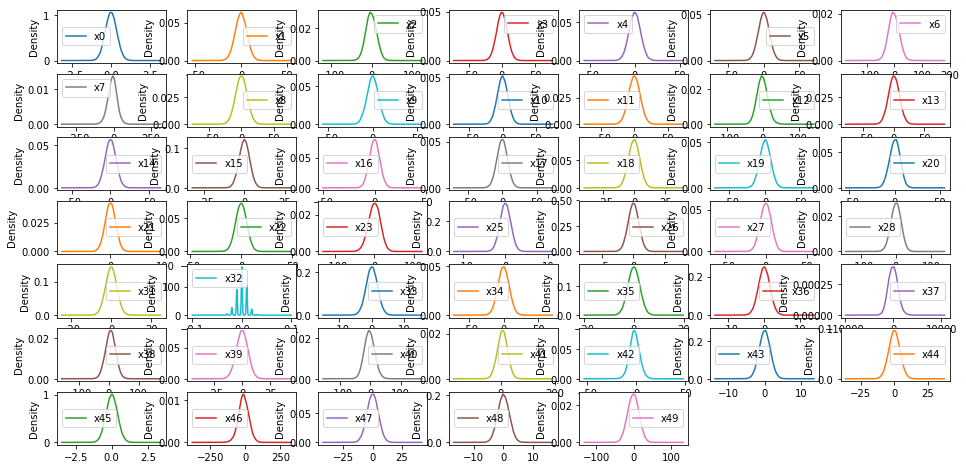

In [22]:
%matplotlib inline
ax = numericTypes.plot(kind='density', figsize=(16,8), subplots=True, layout=(7,7), sharex=False)
plt.xticks([]),plt.yticks([])

### Visualize missingness
One other use of checking the distributions of each variable, is that, one can know how to deal with missing values. If the values are heavily skewed (right/left), then choosing a median imputation is a good idea. On the other hand, if the values are normally distributed as above, one can choose mean/median to impute the missing values. In this case, median imputation was chosen. 

Understanding the missingness pattern in the data is something that should not be overlooked. The pattern of missingness should guide the imputation method. Based on the figure below, it is clear that there is no obvious pattern in the missingness. The missingness appears to be random. 

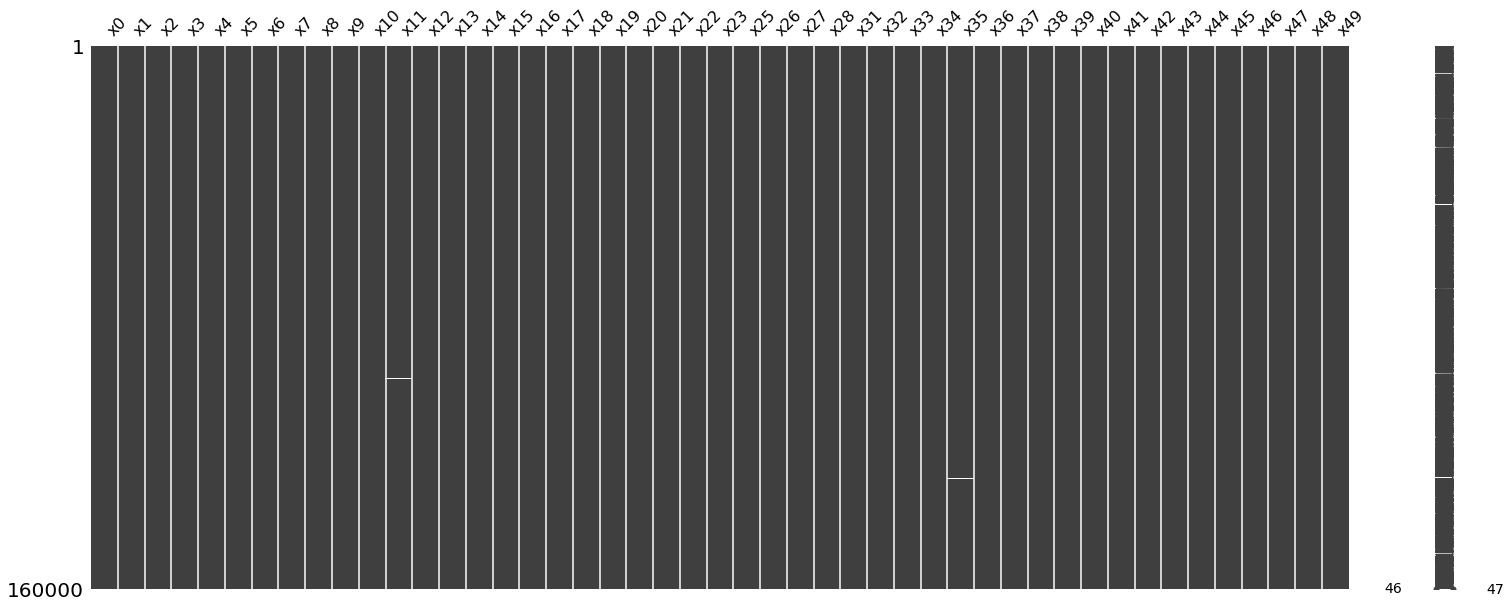

In [8]:
temp = numericTypes.isnull().sum()
temp = temp[temp > 0]
numericTypesMissing = numericTypes[temp.index]
msno.matrix(numericTypesMissing)

## Prepare the Data

### Replacing numeric missing values with median

In [9]:
def replaceNumMissingData(df):
    temp_df = df.copy() 
    columnnames = df.columns
        
    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())
    
    #replacing missing continous values with median
    for i in range(0,len(columnnames)):
        try:
            temp_array =df[df[columnnames[i]]!=np.nan][columnnames[i]] 
            # replace NAs with median for continous variables created from above arrays
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,temp_array.median())     
        except Exception as e:
            print(e.args) 
            
    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df


In [10]:
dataWithoutMissing = replaceNumMissingData(numericTypes)
dataWithoutMissing.info()

##############################
## NA count Before Cleaning ##
##############################
x0     26
x1     25
x2     38
x3     37
x4     26
x5     37
x6     26
x7     27
x8     21
x9     30
x10    43
x11    30
x12    36
x13    31
x14    34
x15    35
x16    26
x17    27
x18    40
x19    35
x20    38
x21    29
x22    27
x23    47
x25    22
x26    36
x27    30
x28    35
x31    39
x32    31
x33    41
x34    41
x35    30
x36    27
x37    23
x38    31
x39    23
x40    36
x41    40
x42    26
x43    37
x44    40
x45    29
x46    31
x47    37
x48    32
x49    32
dtype: int64
##############################
## NA Count After Cleaning  ##
##############################
x0     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
x22    0
x23    0
x25    0
x26    0
x27    0
x28    0
x31    0
x32    0
x33    0
x34    0
x35    0
x36    0
x37    0
x38    0
x39    

### Replace categorical missing values with mode

In [11]:
def replaceCatMissingData(df):
    temp_df = df.copy() 
    columnnames = df.columns
        
    print("##############################")
    print("## NA count Before Cleaning ##")
    print("##############################")
    print(df.isnull().sum())
    
    for i in range(0,len(columnnames)):
        try:
            temp_array = df[df[columnnames[i]]!=np.nan][columnnames[i]] 
            temp_df[columnnames[i]] =temp_df[columnnames[i]].replace(np.nan,str(temp_array.mode()[0]))      
        except Exception as e:
            print(e.args)
            
    print("##############################")
    print("## NA Count After Cleaning  ##")
    print("##############################")
    print(temp_df.isnull().sum())
    df = temp_df
    return df

In [12]:
del objectTypes['x32']
del objectTypes['x37']
dataWithoutMissingCat = replaceCatMissingData(objectTypes)
dataWithoutMissingCat.info()

##############################
## NA count Before Cleaning ##
##############################
x24    28
x29    30
x30    30
dtype: int64
##############################
## NA Count After Cleaning  ##
##############################
x24    0
x29    0
x30    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 3 columns):
x24    160000 non-null object
x29    160000 non-null object
x30    160000 non-null object
dtypes: object(3)
memory usage: 3.7+ MB


Concatenate `dataWithoutMissing`, `dataWithoutMissingCat` and `responseVariable` to create a clean dataset.

In [13]:
cleanData = pd.concat([dataWithoutMissing, dataWithoutMissingCat, responseVariable], axis=1)
cleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
x0     160000 non-null float64
x1     160000 non-null float64
x2     160000 non-null float64
x3     160000 non-null float64
x4     160000 non-null float64
x5     160000 non-null float64
x6     160000 non-null float64
x7     160000 non-null float64
x8     160000 non-null float64
x9     160000 non-null float64
x10    160000 non-null float64
x11    160000 non-null float64
x12    160000 non-null float64
x13    160000 non-null float64
x14    160000 non-null float64
x15    160000 non-null float64
x16    160000 non-null float64
x17    160000 non-null float64
x18    160000 non-null float64
x19    160000 non-null float64
x20    160000 non-null float64
x21    160000 non-null float64
x22    160000 non-null float64
x23    160000 non-null float64
x25    160000 non-null float64
x26    160000 non-null float64
x27    160000 non-null float64
x28    160000 non-null float64
x31    160000 non-nul

### One hot encoding the categorical variables

In [14]:
df = cleanData.copy()

In [15]:
dummyCols = pd.get_dummies(df.loc[:, df.dtypes == 'object'])
dummyCols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 20 columns):
x24_america      160000 non-null uint8
x24_asia         160000 non-null uint8
x24_euorpe       160000 non-null uint8
x29_Apr          160000 non-null uint8
x29_Aug          160000 non-null uint8
x29_Dev          160000 non-null uint8
x29_Feb          160000 non-null uint8
x29_January      160000 non-null uint8
x29_July         160000 non-null uint8
x29_Jun          160000 non-null uint8
x29_Mar          160000 non-null uint8
x29_May          160000 non-null uint8
x29_Nov          160000 non-null uint8
x29_Oct          160000 non-null uint8
x29_sept.        160000 non-null uint8
x30_friday       160000 non-null uint8
x30_monday       160000 non-null uint8
x30_thurday      160000 non-null uint8
x30_tuesday      160000 non-null uint8
x30_wednesday    160000 non-null uint8
dtypes: uint8(20)
memory usage: 3.1 MB


In [16]:
df = pd.concat([df, dummyCols], axis=1)

In [17]:
df.drop(['x24', 'x29', 'x30'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 68 columns):
x0               160000 non-null float64
x1               160000 non-null float64
x2               160000 non-null float64
x3               160000 non-null float64
x4               160000 non-null float64
x5               160000 non-null float64
x6               160000 non-null float64
x7               160000 non-null float64
x8               160000 non-null float64
x9               160000 non-null float64
x10              160000 non-null float64
x11              160000 non-null float64
x12              160000 non-null float64
x13              160000 non-null float64
x14              160000 non-null float64
x15              160000 non-null float64
x16              160000 non-null float64
x17              160000 non-null float64
x18              160000 non-null float64
x19              160000 non-null float64
x20              160000 non-null float64
x21              160000 non-

### Remove highly correlated variables

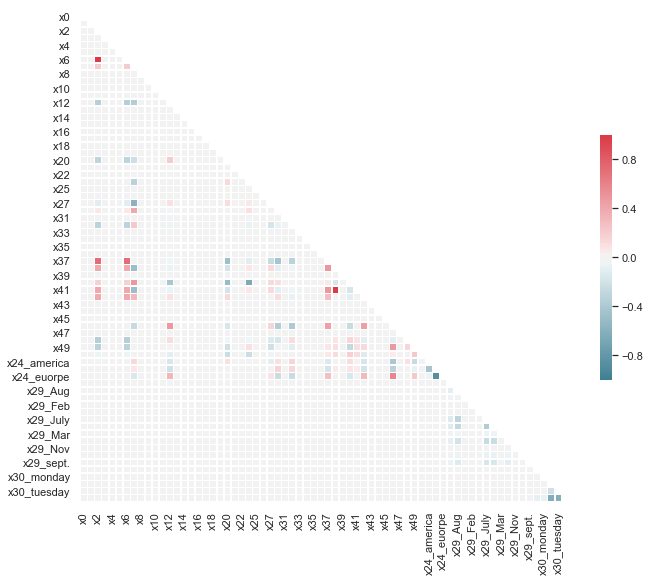

In [18]:

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There does not seem to be much correlation going on, so we can move on.

## Evaluate Algorithms

### Choose a metric

The first step in evaluating the algorithms is to choose a metric. For an imbalanced binary classification problem the most commonly used metric of evaluation is the `roc_auc_score` - which represents the Area under the curve value. Area under the curve (AUC) is a single-number-summary of the performance of a classifier. AUC is the percentage of the ROC plot that is underneath the curve. It turns out that AUC can also be interpreted as follows, if we randomly choose 1 positive observation and 1 negative observation from our testing set, AUC represents the likelihood that our classifier would assign a higher predicted probability to the positive observation. It makes sense that this is useful goal, because ultimately, we want the classifier to rank positive observations higher than negative observations in terms of predicted probability. This the reason why, we will be extracting the predicted probability from the second column of the `predict_proba` output. For instance, `mdl.predict_proba(y_test)[:,1]`, where `y_test` is the true label of the test set and `mdl` is the classifier model we are predicting on.

In [4]:
#df.to_csv('df.csv')
#df = pd.read_csv('df.csv')
#df = df.iloc[:, 1:]

#Create data = x
Cls_X = df.copy()
#create target = Y
Cls_y = Cls_X.y
print('X shape before ')
print(Cls_X.shape)
#drop the response column from the x dataset
Cls_X.pop('y') 

print('X shape after ')
print(Cls_X.shape)
print('Y shape after ')
print(Cls_y.shape)

X shape before 
(160000, 68)
X shape after 
(160000, 67)
Y shape after 
(160000,)


#### Class Distribution and Null Accuracy
There is 60:40 ratio of observations with class labels 0 and 1 respectively and naturally a null accuracy of 60%. That is, a model which randomly predicts 0 for every observations is still 60% accurate. This is typically as a benchmark to see how well our model predictions are when compared with null model.

In [5]:
# Explore distribuion of our class
print("Class distibution")
print(Cls_y.value_counts())

# calculate the percentage of zeros
print('Percentage of 0s: ',round(1 - Cls_y.mean(),4))

# calculate the percentage of ones
print('Percentage of 1s: ', round(Cls_y.mean(),4))

# calculate null accuracy 
print('')
print('##############################')
print('NULL Accuracy: ', max(round(Cls_y.mean(),4), round(1 - Cls_y.mean(),4)))
print('##############################')

Class distibution
0    95803
1    64197
Name: y, dtype: int64
Percentage of 0s:  0.5988
Percentage of 1s:  0.4012

##############################
NULL Accuracy:  0.5988
##############################


### Compare linear and non-linear models
The goal here is to train many models and see which ones are learning the pattern in the data. The `models` variable is a list of tuples, with name and the classifier object. Initially, defaults are used to get an idea of which models are able to learn the pattern in the data. 10-fold crossvalidation is used on the entire dataset and for each fold the roc_auc_score is calculated on the test indicies. The `kfold.split()` method returns a generator which can be used to retrieve the fold's training and test indices. Within each loop the model is fit on the training indices and evaluated on the test indicies. The results of each fold are stored in `cvscores` list. At the end of the loop, the cvscores are stored inside a `results` dictionary. The results dictionary is then converted to a dataframe and the mean scores are computed.

In [47]:
Cls = df.copy()
target_data=Cls.y
Cls.pop('y')
train_data=Cls

In [49]:
# prepare models
models = []

# linear
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
# non-linear
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [51]:
# evaluate each model in turn
results = {}
oofs = {}
scoring = 'roc_auc'
for name, model in models:
    print("Training model :" + name)
    kfold = KFold(n_splits=10, random_state=7)
    oofs[name] = np.zeros(Cls.shape[0])
    cvscores = []
    for train_idx, test_idx in kfold.split(Cls):
        model.fit(train_data.loc[train_idx], target_data.loc[train_idx])
        oofs[name][test_idx] = model.predict_proba(train_data.loc[test_idx])[:,1]
        print("Fold ROC score is %f" % roc_auc_score(target_data[test_idx],oofs[name][test_idx]))
        cvscores.append(roc_auc_score(target_data[test_idx],oofs[name][test_idx]))
    results[name] = cvscores 

Training model :LR
Fold ROC score is 0.755776
Fold ROC score is 0.754715
Fold ROC score is 0.758968
Fold ROC score is 0.760445
Fold ROC score is 0.761291
Fold ROC score is 0.758513
Fold ROC score is 0.763135
Fold ROC score is 0.759802
Fold ROC score is 0.759879
Fold ROC score is 0.759665
Training model :LDA
Fold ROC score is 0.755638
Fold ROC score is 0.754448
Fold ROC score is 0.758941
Fold ROC score is 0.760134
Fold ROC score is 0.761071
Fold ROC score is 0.758328
Fold ROC score is 0.763140
Fold ROC score is 0.759336
Fold ROC score is 0.759578
Fold ROC score is 0.759365
Training model :KNN
Fold ROC score is 0.896217
Fold ROC score is 0.897008
Fold ROC score is 0.897484
Fold ROC score is 0.896951
Fold ROC score is 0.893606
Fold ROC score is 0.894688
Fold ROC score is 0.895257
Fold ROC score is 0.892476
Fold ROC score is 0.895564
Fold ROC score is 0.893309
Training model :CART
Fold ROC score is 0.842974
Fold ROC score is 0.841589
Fold ROC score is 0.844041
Fold ROC score is 0.847429
Fo

In [64]:
resultsDF = pd.DataFrame(results)
print(resultsDF.mean())

LR      0.759219
LDA     0.758998
KNN     0.895256
CART    0.844066
NB      0.747734
dtype: float64


KNN and CART are performing far better than the rest of the classifiers. In the next section, Logistic Regression, KNN and CART are combined into one meta-algorithm called VotingClassifier to yeild slightly better results.

### Ensemble methods

#### Boostrap Aggregation methods:

##### Ensemble of different weak learners
##### Voting Classifier:
The idea behind the `VotingClassifier` is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. Use an ensemble of Logistic Regression, KNN and CART.

Three models are initialized and a list of tuples is constructed. In each iteration, individual models are fit on the `Xtrain` split and validated on the `X_test` split.

In [7]:
# select a seed to use for repeatability
seed = 100

#Split data to  into train and holding set.
X_train,X_test,y_train,y_test = train_test_split(Cls_X, Cls_y, test_size = 0.3, random_state = seed)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(112000, 67)
(112000,)
(48000, 67)
(48000,)


In [71]:
vlr = LogisticRegression(random_state=7)
vknn = KNeighborsClassifier()
vdt = DecisionTreeClassifier(random_state=7)
vClassifiers = [('Logistic Regression', vlr), ('K Nearest Neighbors', vknn), ('Classification Tree', vdt)]

# Iterate over the pre-defined list of classifiers
for vclf_name, vclf in vClassifiers:    
 
    # Fit clf to the training set
    vclf.fit(X_train, y_train)    
   
    # Predict y_pred and get proba
    y_pred = vclf.predict(X_test)
    y_pred_proba = vclf.predict_proba(X_test)[:,1]
    
    # Calculate roc_auc_score
    v_roc_auc_score = roc_auc_score(y_test, y_pred_proba) 
   
    # Evaluate clf's roc_auc_score on the test set
    print('{:s} : {:.3f}'.format(vclf_name, v_roc_auc_score))

Logistic Regression : 0.761
K Nearest Neighbors : 0.892
Classification Tree : 0.838


Next, a VotingClassifier in instantiated with the list of estimators. Voting is set to `soft` since probabilities are used. By combining the above three models, the VotingClassifier's roc_auc_score has improved to **0.929**

In [74]:
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=vClassifiers, voting='soft')     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)[:,1]

# Calculate roc_auc_score
vc_roc_auc_score = roc_auc_score(y_test, y_pred_proba) 
print('Voting Classifier: {:.3f}'.format(vc_roc_auc_score))

Voting Classifier: 0.929


##### BaggingClassifier with DecisionTree base learner

The VotingClassifier uses the same training dataset with different algorithms and the final predictions are obtained by majority voting. Another type of ensemble learner is a Bootstrap aggregation or in short Bagging. In Bagging, the same algorithm is used on different training data subsets. That is, each model is trained on a different subsets of the data. Overall, bagging has the effect of reducing the variance of individual models in the ensemble.  The base estimator to use can be specified when instantiating the BaggingClassifier object. In this case, the BaggingClassifier did quite well with a roc_auc_score of **0.97**

In [77]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=7)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=7)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)
y_pred_proba = bc.predict_proba(X_test)[:,1]

# Evaluate acc_test
bc_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('Test set roc_auc_score of bc: {:.2f}'.format(bc_roc_auc_score)) 

Test set roc_auc_score of bc: 0.97


##### BaggingClassifier with KNeighborsClassifier base learner
The base estimator of the BaggingClassifier can be a KNeighbhorsClassifier. Trying this approach yeilded a roc_auc_score of **0.90**

In [82]:
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate knc
knc = KNeighborsClassifier()

# Instantiate bc
bc_kn = BaggingClassifier(base_estimator=knc, n_estimators=10, random_state=1, n_jobs=-1)

# Fit bc to the training set
bc_kn.fit(X_train, y_train)

# Predict test set labels
y_pred = bc_kn.predict(X_test)
y_pred_proba = bc_kn.predict_proba(X_test)[:,1]

# Evaluate acc_test
bc_kn_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('Test set roc_auc_score of bc with KNN: {:.2f}'.format(bc_kn_roc_auc_score)) 

Test set roc_auc_score of bc with KNN: 0.90


##### Ensemble of DecisionTrees - RandomForestClassifier
With BaggingClassifier, the base estimator can be any model. Each estimator is trained on a distinct bootstrap sample of the training set. Estimators use all features for training and prediction. RandomForest is another type of ensemble learner with DecisionTree as the base estimator. Like in BaggingClassifier, each estimator is trained on a different boostrap sample. But, RF introduces further randomization in the training of individual trees,i.e, when each tree is trained only `d` features are sampled at each node without replacement, where *d < total number of features* . The node is split using the feature that maximizes information gain (IG). By default *d* is the sqrt of the number of features. For example, if there are 100 features, then only 10 features are sampled at each node. Due to this pecularity, it is possible to extract the best features from the model - a thing that is most useful for building robust machine learning models.

The RandomForest itself can be tuned. A grid of parameters is passed the the GridSearch object along with the RandomForestClassifier object. Due to the fact that RandonForest inherently make use of DecisionTrees, it is also possible to pass in the parameters to tune individual trees like the IG criterion, max_depth etc.

In [13]:
tuned_parameters={'n_estimators':[10,20,30,40,50,100], 'criterion':['gini','entropy'], 'max_depth':[5,10,15],
                 'min_samples_split':[2,4,9]}
scores = ['roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score, n_iter=10)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'n_estimators': 40, 'min_samples_split': 9, 'max_depth': 15, 'criterion': 'entropy'}

Grid scores on development set:

0.860 (+/-0.005) for {'n_estimators': 40, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini'}
0.963 (+/-0.002) for {'n_estimators': 40, 'min_samples_split': 9, 'max_depth': 15, 'criterion': 'gini'}
0.964 (+/-0.002) for {'n_estimators': 50, 'min_samples_split': 9, 'max_depth': 15, 'criterion': 'gini'}
0.944 (+/-0.004) for {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 10, 'criterion': 'entropy'}
0.951 (+/-0.004) for {'n_estimators': 10, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'gini'}
0.959 (+/-0.002) for {'n_estimators': 20, 'min_samples_split': 9, 'max_depth': 15, 'criterion': 'gini'}
0.927 (+/-0.003) for {'n_estimators': 10, 'min_samples_split': 4, 'max_depth': 10, 'criterion': 'entropy'}
0.938 (+/-0.003) for {'n_estimators': 30, 'min_samples_split

The best estimator is then used to make predictions on the test set. The roc_auc_score in this case was observed to be: **0.966**

In [14]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
# get the best model and make predictions
bestRF_mdl = clf.best_estimator_
RF_ypred = bestRF_mdl.predict(X_test)
RF_ypred_prob = bestRF_mdl.predict_proba(X_test)[:,1]
# calculate the roc_auc_score on X_test
roc_auc_score(y_test, RF_ypred_prob)

0.9665118297620746

##### Extract important features from RandomForestClassifier
The most important features contributing to the model can be extracted using the `feature_importances_` attribute of the best estimator. The top features are plotted and it can be readily observed that only the first 17 attributes are  significantly contributing to the model. In the next section, the model is trained using only these top 17 features to show how using a simpler model, at times, yields even better results than using the full model. This principle is called the `Occum's Razor`. The idea here is that simple models tend to be more robust than complex models.

   feature  importance
23     x23    0.085280
20     x20    0.070743
46     x49    0.067521
45     x48    0.062922
27     x28    0.057728
39     x42    0.057319
12     x12    0.053220
26     x27    0.052421
34     x37    0.046483
7       x7    0.045977
37     x40    0.045037
35     x38    0.039564
38     x41    0.037709
43     x46    0.036343
2       x2    0.034945
6       x6    0.031490
29     x32    0.031396
3       x3    0.004695
41     x44    0.004548
0       x0    0.004461


Text(0.5,1,'Random Forest Features importance')

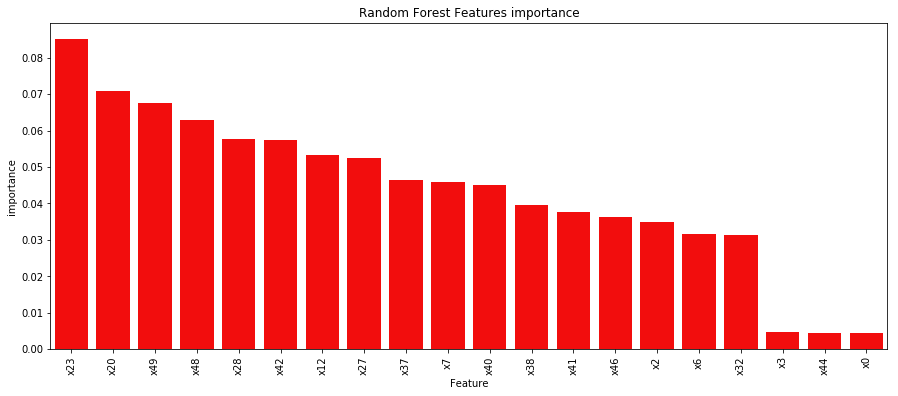

In [26]:
# get the best predictors
importances = pd.DataFrame({'feature':X_train.columns, 'importance': bestRF_mdl.feature_importances_}) 
importances = importances.sort_values('importance',ascending=False)
 
# display top 20
topDF1 = importances.head(20)
print(topDF1)

f, ax = plt.subplots(figsize=(15, 6))

g = sns.barplot('feature', y="importance", data=topDF1, color="red", saturation=.9, ci=68)
g =plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Random Forest Features importance')

#### Boosting methods
Boosting refers to an ensemble method in which several models are trained sequentially with each model learning from the errors of its predecessors.

##### Adaptive boosting - AdaBoostClassifier
In Adaptive boosting, each predictor pays more attention to the instances wrongly predicted by its predecessor, by constantly changing the weights of training instances. Furthermore, each predictor is assigned a coefficient alpha, that weighs its contribution in the ensemble's final prediction. 

Any classifier can be used as a base estimator. At first an un-tuned DecisionTree with 50 estimators is tried. This resulted a roughly same performance as the baseline DecisionTree model with an roc_auc_score of **0.84**

In [83]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

# Instantiate dt
dt_ada = DecisionTreeClassifier(random_state=7)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt_ada, n_estimators=50, random_state=7)

#Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]

# Evaluate acc_test
ada_roc_auc_score = roc_auc_score(y_test, y_pred_proba)
print('Test set roc_auc_score of adaboosting: {:.2f}'.format(ada_roc_auc_score)) 

Test set roc_auc_score of adaboosting: 0.84


A tuned DecisionTree perfomed much better than the base line DecisionTree with a roc_auc_score of **0.908**

##### Find the best tree

In [108]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

dt_tune = DecisionTreeClassifier(random_state=7)

# optimize max_depth; max_features and min_samples_leaf
params_dt = {
    'max_depth': [5,10,15,20],
    'min_samples_leaf': [0.08, 1],
    'criterion': ['gini', 'entropy']
}

# instantiate a RandomSearchCV object
grid_dt = RandomizedSearchCV(estimator=dt_tune, param_distributions = params_dt, 
                             scoring='roc_auc', cv=5, n_jobs=-1, n_iter=10)
grid_dt.fit(X_train, y_train)

ypred = grid_dt.predict(X_test)
ypred_proba = grid_dt.predict_proba(X_test)[:,1]

# Evaluate acc_test
dt_tune_roc_auc_score = roc_auc_score(y_test, ypred_proba)
print('Test set roc_auc_score of DecisionTree: {:.5f}'.format(dt_tune_roc_auc_score))

Test set roc_auc_score of DecisionTree: 0.90866


In [105]:
grid_dt.best_params_

{'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}

Use the model with these hyperparameters in the next section where Boosting is done.

##### Tuning AdaBoostClassifier
AdaBoostClassifier itself can be tune further to find the best learning_rate and the optimal number of estimators to use.

In [112]:
tuned_parameters={'n_estimators':[10,20,30,40,50,100,200], 'learning_rate': [0.01, 0.1, 1]}
scores = ['roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    # Instantiate dt
    dt_ada = DecisionTreeClassifier(min_samples_leaf=1, max_depth=10, 
                                    criterion='entropy', random_state=7)
    
    clf_ada = RandomizedSearchCV(AdaBoostClassifier(base_estimator=dt_ada), tuned_parameters, cv=5,
                       scoring='%s' % score, n_iter=10, verbose=1, n_jobs=-1)
    clf_ada.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf_ada.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_ada.cv_results_['mean_test_score']
    stds = clf_ada.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_ada.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf_ada.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 140.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 144.3min finished


Best parameters set found on development set:

{'n_estimators': 100, 'learning_rate': 0.01}

Grid scores on development set:

0.945 (+/-0.009) for {'n_estimators': 20, 'learning_rate': 0.01}
0.962 (+/-0.005) for {'n_estimators': 100, 'learning_rate': 0.1}
0.925 (+/-0.006) for {'n_estimators': 100, 'learning_rate': 1}
0.965 (+/-0.004) for {'n_estimators': 200, 'learning_rate': 0.1}
0.958 (+/-0.002) for {'n_estimators': 20, 'learning_rate': 0.1}
0.953 (+/-0.007) for {'n_estimators': 30, 'learning_rate': 0.01}
0.932 (+/-0.008) for {'n_estimators': 10, 'learning_rate': 0.01}
0.969 (+/-0.003) for {'n_estimators': 100, 'learning_rate': 0.01}
0.956 (+/-0.006) for {'n_estimators': 40, 'learning_rate': 0.01}
0.910 (+/-0.003) for {'n_estimators': 10, 'learning_rate': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.92      0.95      

The best estimator was found to be one which uses a learning rate of *0.01* with *100* estimators. Predictions using this estimator resulted in a roc_auc_score of **0.968**

In [113]:
clf_ada.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=None)

In [114]:
# get the best model and make predictions
ada_best = clf_ada.best_estimator_
ada_best_ypred = ada_best.predict(X_test)
ada_best_ypred_prob = ada_best.predict_proba(X_test)[:,1]

# calculate the roc_auc_score on X_test
roc_auc_score(y_test, ada_best_ypred_prob)

0.9686331486097618

Since a DecisionTree base estimator was used in the AdaptiveBoosting meta algorithm, it is possible to extract the best features. The best features contributing the model are extracted and plotted.

Interestingly, even using AdaBoosting gave 17 best predictors that are contributing the most to the model's performance.

   feature  importance
45     x48    0.108718
12     x12    0.096015
23     x23    0.074627
39     x42    0.072313
26     x27    0.071410
20     x20    0.070695
27     x28    0.069197
46     x49    0.068749
34     x37    0.063748
43     x46    0.044468
29     x32    0.041231
7       x7    0.040534
38     x41    0.036494
2       x2    0.029015
35     x38    0.027606
37     x40    0.023242
6       x6    0.017873
36     x39    0.001677
41     x44    0.001653
32     x35    0.001636


Text(0.5,1,'AdaBoosting Features importance')

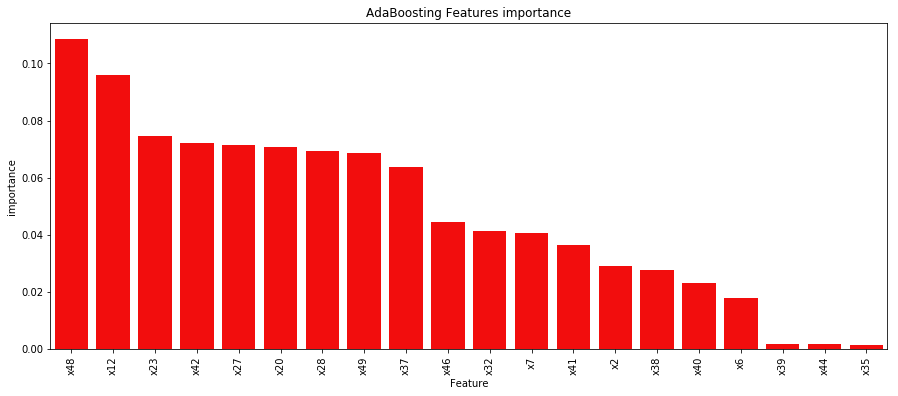

In [115]:
# get the best predictors
#bestRF_mdl.feature_importances_

importances = pd.DataFrame({'feature':X_train.columns, 'importance': ada_best.feature_importances_}) 
importances = importances.sort_values('importance',ascending=False)#.set_index('feature') 
 
#only display top 20 importances[:10].plot.bar()
topDF1 = importances.head(20)
print(topDF1)

f, ax = plt.subplots(figsize=(15, 6))

g = sns.barplot('feature', y="importance", data=topDF1, color="red", saturation=.9, ci=68)
g =plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('AdaBoosting Features importance')

The top 17 features from AdaBoosting are collected into `Ada_importantFeatures` for later use.

In [117]:
Ada_importantFeatures = list(topDF1.iloc[0:17,0])
X_train_simple_ada = X_train[Ada_importantFeatures]
X_test_simple_ada = X_test[Ada_importantFeatures]
print(X_train_simple_ada.shape)
print(y_train.shape)
print(X_test_simple_ada.shape)
print(y_test.shape)

(112000, 17)
(112000,)
(48000, 17)
(48000,)


### Compare Bagging and Boosting methods

#### Compare RandomForestClassifier with AdaBoostClassifier
As RandomForestClassifer and AdaBoostClassifier ensemble methods both gave out 17 features to be the most useful in predicting the y label, it is interesting to see if these are the same exact 17 features.

The intersection of the features from both Bagging and Boosting ensembles are exactly the same. However, the order of importance varies. 

In [121]:
def intersection(list1, list2):
    list3 = [value for value in list1 if value in list2]
    return list3

print(intersection(Ada_importantFeatures, importantFeatures))
print(len(intersection(Ada_importantFeatures, importantFeatures)))

['x48', 'x12', 'x23', 'x42', 'x27', 'x20', 'x28', 'x49', 'x37', 'x46', 'x32', 'x7', 'x41', 'x2', 'x38', 'x40', 'x6']
17


## Improve Results
In this section, the features extracted from Bagging and Boosting methods are used to tune the RandomForestClassifier and Stochastic Gradient Boosting classifier. The tuned models are then used on the test data to see if there were any improvements to the roc_auc_score.

### ensemble of decision trees with important features
At first the training and test sets are trimmed to use only these top 17 features.

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(112000, 67)
(112000,)
(48000, 67)
(48000,)


In [40]:
importantFeatures = list(topDF1.iloc[0:17,0])
X_train_simple = X_train[importantFeatures]
X_test_simple = X_test[importantFeatures]
print(X_train_simple.shape)
print(y_train.shape)
print(X_test_simple.shape)
print(y_test.shape)

(112000, 17)
(112000,)
(48000, 17)
(48000,)


In [41]:
tuned_parameters={'n_estimators':[10,20,30,40,50,100], 'criterion':['gini','entropy'], 'max_depth':[5,10,15],
                 'min_samples_split':[2,4,9]}
scores = ['roc_auc']

for score in scores:
    print("# Tuning REDUCED MODEL's hyper-parameters for %s" % score)
    print()

    clf_reduced = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s' % score, n_iter=10)
    
    ## NOTE this time using reduced model
    clf_reduced.fit(X_train_simple, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf_reduced.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_reduced.cv_results_['mean_test_score']
    stds = clf_reduced.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_reduced.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf_reduced.predict(X_test_simple)
    print(classification_report(y_true, y_pred))
    print()

# Tuning REDUCED MODEL's hyper-parameters for roc_auc

Best parameters set found on development set:

{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'entropy'}

Grid scores on development set:

0.968 (+/-0.002) for {'n_estimators': 10, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'gini'}
0.975 (+/-0.001) for {'n_estimators': 40, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'gini'}
0.875 (+/-0.007) for {'n_estimators': 100, 'min_samples_split': 9, 'max_depth': 5, 'criterion': 'gini'}
0.873 (+/-0.006) for {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 5, 'criterion': 'entropy'}
0.975 (+/-0.001) for {'n_estimators': 40, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'gini'}
0.973 (+/-0.001) for {'n_estimators': 20, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'gini'}
0.873 (+/-0.003) for {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 5, 'criterion': 'entropy'}
0.977 (+/-0.001) for {'n_estimators': 50, 'mi

In [42]:
# get the best model and make predictions
bestRF_mdl_reduced = clf_reduced.best_estimator_
RF_ypred_reduced = bestRF_mdl_reduced.predict(X_test_simple)
RF_ypred_prob_reduced = bestRF_mdl_reduced.predict_proba(X_test_simple)[:,1]

# calculate the roc_auc_score on X_test_simple
roc_auc_score(y_test, RF_ypred_prob_reduced)

0.9776587629348727

Using a simpler model gives a better performance than using the entire model with a roc_auc_score of **0.977**. Simple models are more robust. 

In [45]:
bestRF_mdl_reduced

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Gradient Boosting with important features
Gradient boosting takes the errors of the previous predictor and corrects them. In contrast to AdaBoost, the weights of the instances are not tweaked, instead, each predictor is trained using its predecessor's residual errors as labels. GradientBoosting Trees take the base learn as CART models, hence we can specify in the parameter grid params which are applicable for tuning Trees.

In this case, only the top 17 features identified in the previous section are used to perform the Stochastic Gradient Boosting. In SGB each tree is trained on a random subset of rows of the training data. The subset is sampled without replacement. The percent to rows to use as subset is given by `subsample` param of the GradientBoostingClassifier. Furthermore, features are sampled (without replacement) when choosing split points. The result of this that it adds further ensemble diversity and the net effect of this is that it adds further variance to the ensemble trees. 

In [125]:
from sklearn.ensemble import GradientBoostingClassifier
tuned_parameters={'n_estimators':[40,50,100], 'max_depth':[5,10,15],
                 'min_samples_split':[2,4,9], 'max_features': [0.6, 0.8]}
scores = ['roc_auc']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_gb = RandomizedSearchCV(GradientBoostingClassifier(subsample=0.9), tuned_parameters, cv=5,
                       scoring='%s' % score, n_iter=10, n_jobs = -1, verbose=2)
    clf_gb.fit(X_train_simple_ada, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf_gb.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_gb.cv_results_['mean_test_score']
    stds = clf_gb.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_gb.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf_gb.predict(X_test_simple_ada)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for roc_auc

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5 
[CV] n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5 
[CV] n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5 
[CV] n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5 
[CV]  n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5, total=  37.4s
[CV] n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5 
[CV]  n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5, total=  37.6s
[CV]  n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5, total=  37.6s
[CV] n_estimators=100, min_samples_split=9, max_features=0.6, max_depth=5 
[CV] n_estimators=100, min_samples_split=9, max_features=0.6, max_depth=5 
[CV]  n_estimators=50, min_samples_split=9, max_features=0.6, max_depth=5, total=  38.3s
[CV] n_estimators=100, m

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 94.0min


[CV]  n_estimators=40, min_samples_split=9, max_features=0.8, max_depth=15, total=20.0min
[CV] n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15 
[CV]  n_estimators=40, min_samples_split=9, max_features=0.8, max_depth=15, total=19.2min
[CV] n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15 
[CV]  n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15, total=61.4min
[CV] n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15 
[CV]  n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15, total=59.1min
[CV] n_estimators=50, min_samples_split=2, max_features=0.8, max_depth=15 
[CV]  n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15, total=59.8min
[CV] n_estimators=50, min_samples_split=2, max_features=0.8, max_depth=15 
[CV]  n_estimators=100, min_samples_split=2, max_features=0.8, max_depth=15, total=57.9min
[CV] n_estimators=50, min_samples_split=2, max_features=0.8, max_depth=15 
[CV

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 209.9min finished


Best parameters set found on development set:

{'n_estimators': 100, 'min_samples_split': 9, 'max_features': 0.8, 'max_depth': 15}

Grid scores on development set:

0.941 (+/-0.003) for {'n_estimators': 50, 'min_samples_split': 9, 'max_features': 0.6, 'max_depth': 5}
0.959 (+/-0.004) for {'n_estimators': 100, 'min_samples_split': 9, 'max_features': 0.6, 'max_depth': 5}
0.985 (+/-0.001) for {'n_estimators': 100, 'min_samples_split': 9, 'max_features': 0.8, 'max_depth': 15}
0.983 (+/-0.001) for {'n_estimators': 100, 'min_samples_split': 9, 'max_features': 0.6, 'max_depth': 10}
0.983 (+/-0.001) for {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 0.8, 'max_depth': 10}
0.978 (+/-0.001) for {'n_estimators': 40, 'min_samples_split': 4, 'max_features': 0.8, 'max_depth': 10}
0.981 (+/-0.002) for {'n_estimators': 40, 'min_samples_split': 9, 'max_features': 0.8, 'max_depth': 15}
0.984 (+/-0.001) for {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 0.8, 'max_depth': 15}


The best estimator was found to be `{'n_estimators': 100, 'min_samples_split': 9, 'max_features': 0.8, 'max_depth': 15}` with an roc_auc_score on the test set of **0.985**. 

In [126]:
clf_gb.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=0.8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=9,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.9, verbose=0,
              warm_start=False)

In [127]:
# get the best model and make predictions
gb_best = clf_gb.best_estimator_
gb_best_ypred = gb_best.predict(X_test_simple_ada)
gb_best_ypred_prob = gb_best.predict_proba(X_test_simple_ada)[:,1]

# calculate the roc_auc_score on X_test
roc_auc_score(y_test, gb_best_ypred_prob)

0.9853109879331402

### Summarize the models
Using roc_auc_score as the metric, the best model for predicting the label of y is found to be `Tuned Stochastic Gradient Boosting Classifier` with score of `0.985`

In [31]:
modelSummary = {
    'Tuned Stochastic GradientBoostingClassifer with top 17 features': 0.985,
    'Tuned RandomForestClassifier with top 17 features': 0.977,
    'Tuned Adaptive Boosting DecisionTree': 0.968,
    'UnTuned Adaptive Boosting DecisionTree': 0.84,
    'Tuned DecisionTreeClassifier': 0.908,
    'Tuned RandomForestClassifier': 0.966,
    'VotingClassifier': 0.929,
    'BaggingClassifier with DT': 0.97,
    'BaggingClassifier with KNN': 0.90,
    'LogisticRegression': 0.759,
    'LinearDiscriminantAnalysis': 0.758,
    'KNeighborsClassifier': 0.895,
    'CART': 0.844,
    'NaiveBayesClassifier': 0.747
}

modelSummarySeries = pd.Series(modelSummary)
modelSummarySeries.sort_values(ascending=False)

Tuned Stochastic GradientBoostingClassifer with top 17 features    0.985
Tuned RandomForestClassifier with top 17 features                  0.977
BaggingClassifier with DT                                          0.970
Tuned Adaptive Boosting DecisionTree                               0.968
Tuned RandomForestClassifier                                       0.966
VotingClassifier                                                   0.929
Tuned DecisionTreeClassifier                                       0.908
BaggingClassifier with KNN                                         0.900
KNeighborsClassifier                                               0.895
CART                                                               0.844
UnTuned Adaptive Boosting DecisionTree                             0.840
LogisticRegression                                                 0.759
LinearDiscriminantAnalysis                                         0.758
NaiveBayesClassifier                               

## Deploy the model
Finding an accurate machine learning model is not the end of the project. It is imperative to save the model for future predictions on the new data. Training computationally intensive models like Gradient Boosting takes a considerable amount of time. One way to save the models is by using the pickle module's `dump` utility. The best model can be exported to other systems and integrated into a larger pipeline. It is important to remember that this model expects the same number of features as was used to train the model.

In [128]:
from pickle import dump
from pickle import load
filename = 'gb_best.sav'
dump(gb_best, open(filename, 'wb'))
dump(importantFeatures, open('importantFeaturesRF.sav', 'wb'))
dump(Ada_importantFeatures, open('importantFeaturesAda.sav', 'wb'))
dump(ada_best, open('ada_best_full.sav', 'wb'))
dump(bestRF_mdl_reduced, open('rf_best.sav', 'wb'))

## Present Results and Insights

A variety of classifier models were tried out to find which model yields the best score. Machine Learning is an emperical process, where there is some trail and error involved. But, it is possible to improve the performance of a model through a scientific process by understanding how the model parameters play a role. A general approach has been followed by training a variety of classifiers and the knowledge gained in each step was applied to training meta algorithms like Bagging and Boosting. A useful feature of using these ensemble learners with decision tree base estimators is that one can extract the top features contributing to the identification of patterns in the data. 

Interestingly, both ensemble methods have identified that only the same 17 features are required to predict the label of y. Given this knowledge, the researcher can narrow down his/her analysis by focusing on these features. 

A simple model is more robust and the predictions obtained from such a model can be considered more reliable.

In [36]:
importantFeaturesRF = load(open('importantFeaturesRF.sav', 'rb'))
importantFeaturesADA = load(open('importantFeaturesAda.sav', 'rb'))
impFeatures = pd.DataFrame({'Bagging': importantFeaturesRF, 
                          'Boosting': importantFeaturesADA})
impFeatures

,Bagging,Boosting
0,x23,x48
1,x20,x12
2,x49,x23
3,x48,x42
4,x28,x27
5,x42,x20
6,x12,x28
7,x27,x49
8,x37,x37
9,x7,x46
